# **Part 2 | Multi-Factor Analysis**
*An Analysis of Fama and French 5 Faktor Model with Momentum (and ESG Factor) on several ETFs on a 10-year time horizon*

In [1]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


In [2]:
#General Imports
import pandas as pd
import numpy as np
import os
import warnings

#Plotting
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

#Data Import
import yfinance as yf
import mplfinance as mpf

#Working with Data
from functools import reduce #Get Monthly Data
from datetime import datetime, timedelta
import datetime as dt
from pandas.tseries.offsets import MonthEnd

#Estimation
import statsmodels.api as sm #Regression
from scipy import stats #Correlation
from scipy.stats import kendalltau, spearmanr #Kendal Tau

#Other Stuff
from IPython.display import display, Markdown  # For Markdown rendering

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## **1. Data Collection**

### **1.1 Import ESG Data**

In [47]:
esg_data = pd.read_csv("__data/return_history.csv", delimiter = ",") #Importing ESG Factor Data

In [48]:
esg_data_subsetted = esg_data.rename(columns={"Average_Return_High": "return_high_esg", "Average_Return_Low": "return_low_esg"})
esg_data_subsetted = esg_data_subsetted[["Date", "return_high_esg", "return_low_esg", "ESG_Factor"]]

esg_data_subsetted["Date"] = pd.to_datetime(esg_data["Date"])
esg_data_subsetted['Date'] = esg_data_subsetted["Date"].dt.date

In [49]:
esg_data.tail()

,Date,Average_Return_High,Count_High,Average_Return_Low,Count_Low,ESG_Factor
263,2023-12-31,0.083022,373,0.115144,373,0.032122
264,2024-01-31,-0.018097,373,-0.037933,373,-0.019836
265,2024-02-29,0.031722,373,0.045612,373,0.013890
266,2024-03-31,0.046259,373,0.027716,373,-0.018543
267,2024-04-30,-0.047620,373,-0.065576,373,-0.017956


### **1.2 Importing Single Stock Data**

In [50]:
#Imports Stock Returns
stock_returns = pd.read_excel("__data/Stock_Data_Wide_Format.xlsx", "ReturnTotal")

In [51]:
#Divides Stock Return values by 100 to get decimal values
stock_returns.loc[:, stock_returns.columns != "Date"] = stock_returns.loc[:, stock_returns.columns != "Date"].apply(lambda x: x / 100)

In [71]:
stock_returns["Date"] = pd.to_datetime(stock_returns["Date"])

In [72]:
stock_returns.tail()

,Date,A.N,AA.N,AAL.OQ,AAON.OQ,AAP.N,AAPL.OQ,AAT.N,ABBV.N,ABCB.N,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
185,2024-06-30,-0.005981,-0.101423,-0.014783,0.163717,-0.103482,0.095553,0.044880,0.063756,0.011011,...,-0.063574,0.113823,-0.036164,-0.055398,-0.010918,-0.044437,0.039902,0.004168,0.022411,-0.061003
186,2024-07-31,0.092844,-0.169432,-0.060900,0.014787,0.003973,0.054411,0.184987,0.090424,0.239588,...,0.083879,0.141101,0.002793,0.025984,0.136795,-0.130245,-0.110415,0.191377,0.041036,0.104082
187,2024-08-31,0.010750,-0.025335,-0.001880,0.078843,-0.284541,0.032345,0.027526,0.059303,0.012153,...,-0.024909,0.423419,0.020794,0.036911,-0.016544,0.020677,-0.129401,-0.032311,0.019162,0.001645
188,2024-09-30,0.038903,0.201869,0.058380,0.130130,-0.139484,0.017467,-0.006791,0.005960,0.014766,...,0.017609,0.094090,0.035503,-0.062966,0.072210,-0.004297,0.043478,-0.047215,0.064799,0.108233
189,2024-10-31,-0.120960,0.041676,0.192171,0.059162,-0.078540,-0.030429,0.008608,0.040698,-0.006411,...,-0.141847,0.109837,-0.061198,-0.009541,0.031459,-0.049116,0.070736,0.102499,-0.082752,0.004452


### **1.3 Importing Momentum Factor Data**

In [53]:
def prepMomentumData(data, suffix):

  data_adj = data.copy()

  data_adj["date"] = pd.to_datetime(data_adj["date"], errors='coerce')
  data_adj["date"] = data_adj["date"].dt.date

  data_adj = data_adj.rename(columns={'date': 'Date'})
  data_adj = data_adj.rename(columns={'ret': f"Mom_{suffix}_Factor"})

  data_adj = data_adj[["Date", f"Mom_{suffix}_Factor"]]

  return data_adj

In [54]:
mom_12_1 = pd.read_csv('__data/[usa]_[resff3_12_1]_[monthly]_[ew].csv', delimiter = ",") #Importing Momentum Data
mom_6_1 = pd.read_csv('__data/[usa]_[resff3_6_1]_[monthly]_[ew].csv', delimiter = ",") #Importing Momentum Data

In [55]:
mom_6_1 = prepMomentumData(mom_6_1, "6_1")
mom_12_1 = prepMomentumData(mom_12_1, "12_1")

In [56]:
mom_6_1.tail()

,Date,Mom_6_1_Factor
843,2023-08-31,0.016517
844,2023-09-30,0.000538
845,2023-10-31,-0.014745
846,2023-11-30,0.027283
847,2023-12-31,-0.016531


### **1.4. Importing Fama and French Data**

In [57]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2, index_col=0)


In [79]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, index_col=0)

# Convert the index to datetime
ff5.index = pd.to_datetime(ff5.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')
    ff5[col] = ff5[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Drop observations older than 2009-01-01
ff5 = ff5[ff5.index >= '2009-01-01']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index
ff5['Date'] = ff5["Date"].dt.date

# Sort columns and drop index
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
ff5.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,2009-01-31,-0.0812,-0.0214,-0.1129,0.0018,-0.0116,0.0000
1,2009-02-28,-0.1010,-0.0133,-0.0695,0.0120,-0.0102,0.0001
2,2009-03-31,0.0895,0.0067,0.0347,-0.0252,-0.0225,0.0002
3,2009-04-30,0.1018,0.0713,0.0536,0.0131,0.0012,0.0001
4,2009-05-31,0.0521,-0.0232,0.0028,-0.0078,-0.0216,0.0000


### **1.5 Merging Data**

In [125]:
# Merge all datasets on the Date column
dataframes = [esg_data_subsetted, mom_12_1, mom_6_1, ff5, stock_returns]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

#Merge data
data = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

# Display the first few rows and column names of the resulting dataframe
data.tail()

,Date,return_high_esg,return_low_esg,ESG_Factor,Mom_12_1_Factor,Mom_6_1_Factor,Mkt-RF,SMB,HML,RMW,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
175,2023-08-31,-0.035506,-0.033992,0.001514,0.021640,0.016517,-0.0239,-0.0368,-0.0108,0.0342,...,0.172535,-0.080293,-0.055820,-0.137749,-0.106994,-0.080943,-0.295268,-0.060973,0.012866,-0.024564
176,2023-09-30,-0.052370,-0.056205,-0.003836,0.006053,0.000538,-0.0524,-0.0179,0.0145,0.0185,...,-0.034635,-0.124195,-0.034318,-0.055914,-0.139922,-0.044411,-0.089900,-0.017183,-0.086767,-0.054018
177,2023-10-31,-0.051603,-0.057110,-0.005507,0.004473,-0.014745,-0.0318,-0.0405,0.0019,0.0247,...,-0.118208,-0.116597,-0.032656,-0.069595,-0.114573,-0.050714,-0.209756,-0.115792,-0.095442,-0.055675
178,2023-11-30,0.090709,0.096319,0.005610,0.047826,0.027283,0.0883,-0.0011,0.0166,-0.0381,...,0.002822,0.309508,0.043727,0.113974,0.131548,0.055574,0.108796,0.168970,0.125287,0.115560
179,2023-12-31,0.083022,0.115144,0.032122,0.000407,-0.016531,0.0487,0.0733,0.0492,-0.0304,...,0.214353,-0.031880,0.040701,0.048410,0.153388,0.052805,0.286708,0.231266,0.117168,-0.001019


In [81]:
#Len data
len(data)

180

## **2 Visualizing Data**

### **2.1 Return Distributions**

In [82]:
def plotXReturnDistributions(data_list, column_names, labels, colors, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.kdeplot(data[column_name], color = colors[i], label = labels[i], fill = False, alpha = 0.35)

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG data**

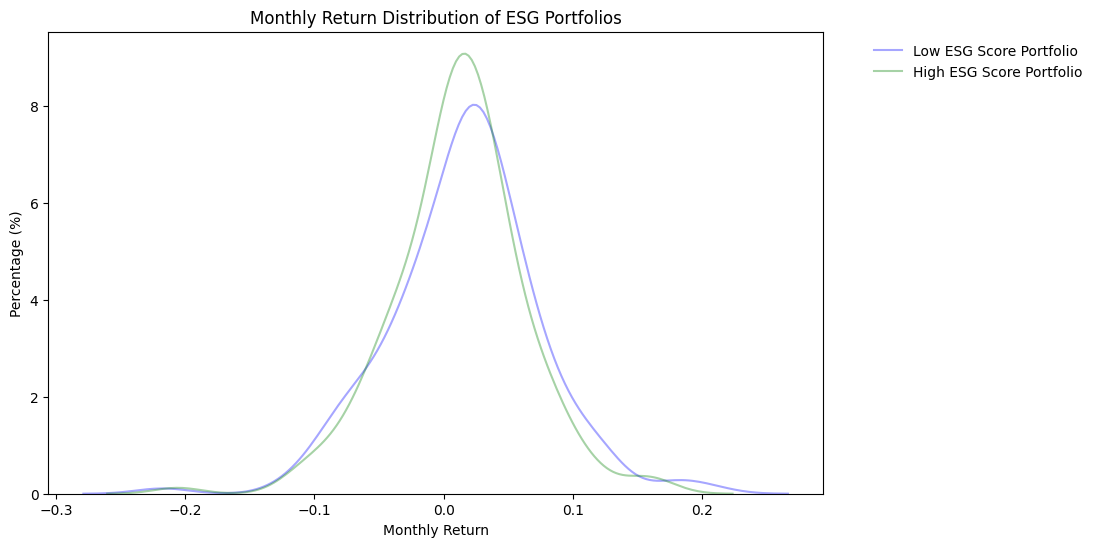

In [83]:
data_list = [data, data]
column_names = ["return_low_esg", "return_high_esg"]
labels = ["Low ESG Score Portfolio", "High ESG Score Portfolio"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of ESG Portfolios",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Momentum Factor**

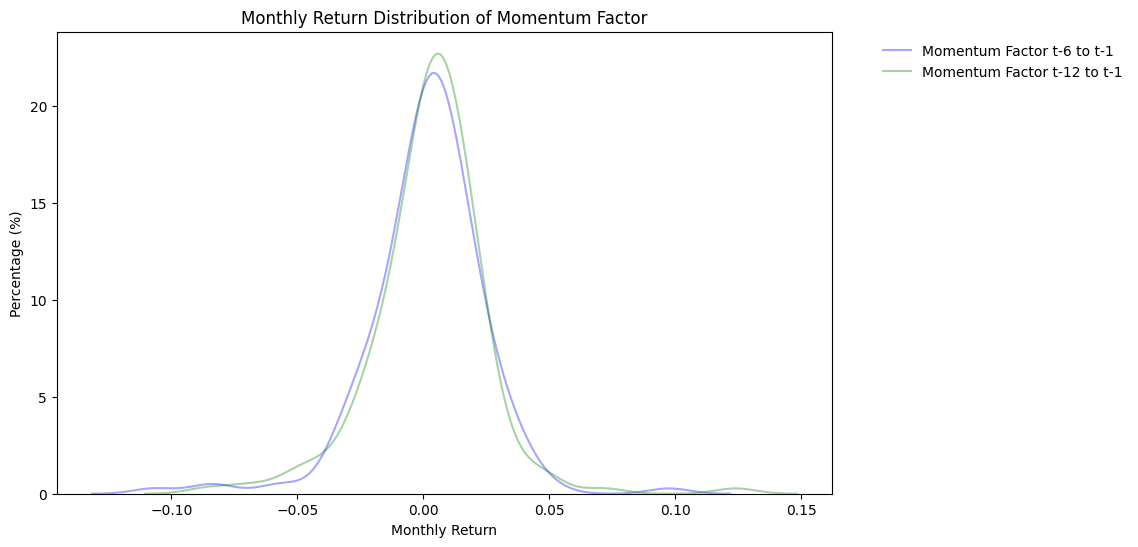

In [84]:
data_list = [data, data]
column_names = ["Mom_6_1_Factor", "Mom_12_1_Factor"]
labels = ["Momentum Factor t-6 to t-1", "Momentum Factor t-12 to t-1"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Momentum Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Fama French 5 Factors**

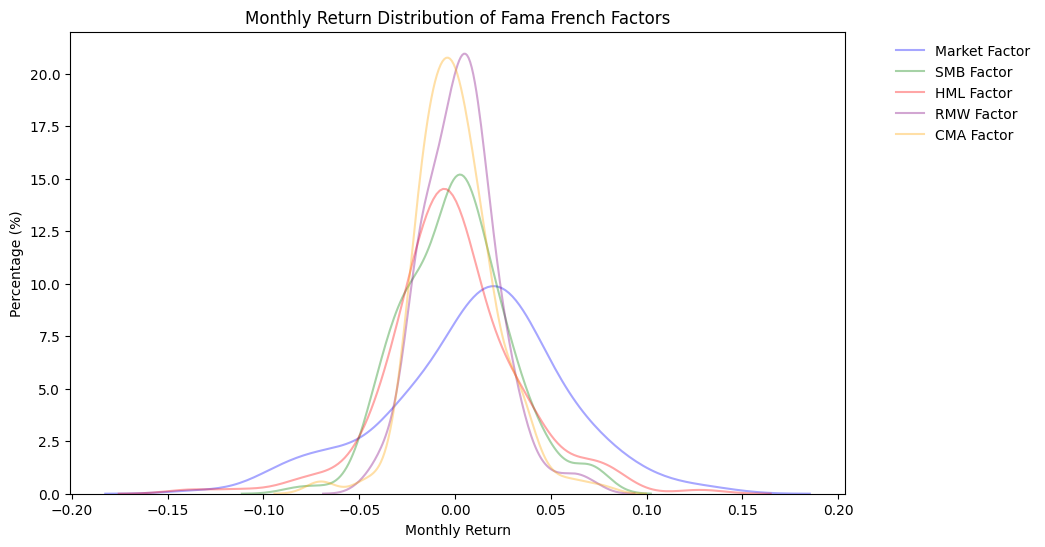

In [87]:
data_list = [data, data, data, data, data]

column_names = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]
labels = ["Market Factor", "SMB Factor", "HML Factor", "RMW Factor", "CMA Factor"]
colors = ["blue", "green", "red", "purple", "orange"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Fama French Factors",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Comparison**

*Distribution Characteristics:*
- Both High and Low ESG Score portfolios exhibit similar distribution shapes to the broader market indices, suggesting ESG screening may not significantly impact return patterns
- The Momentum Factor curves (both 6-1 and 12-1) stand out with notably higher and narrower peaks, indicating more consistent returns but potentially lower overall returns

*Risk Implications:*
- Narrower distributions (Momentum Factors): Lower volatility with more predictable returns
- ESG portfolios: Risk profile similar to broad market indices

### **2.2 Returns over Time**

In [89]:
def plotXReturnsOverTime(data_list, column_names, labels, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.lineplot(data = data, x = "Date", y = column_name, label = labels[i])

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG Factor**

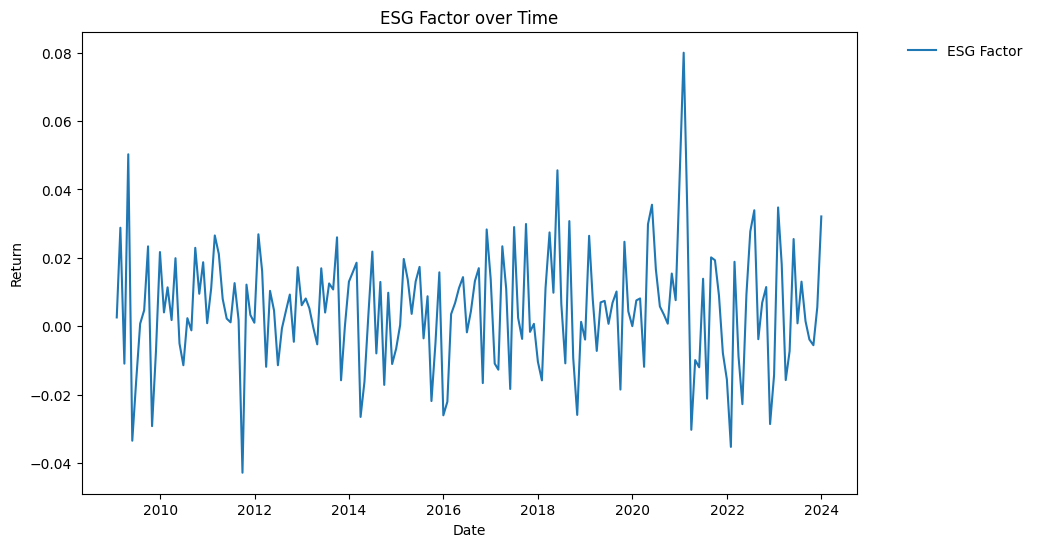

In [90]:
data_list = [data]
column_names = ["ESG_Factor"]
labels = ["ESG Factor"]

plotXReturnsOverTime(data_list, column_names, labels, "ESG Factor over Time", "Date", "Return")

**Momentum Factor**

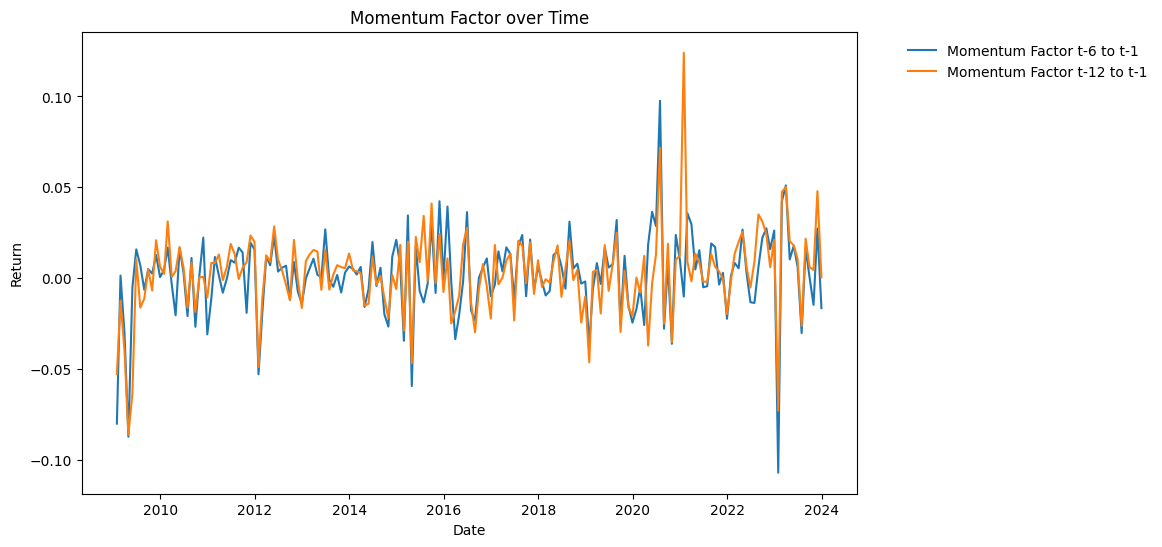

In [91]:
data_list = [data, data]
column_names = ["Mom_6_1_Factor", "Mom_12_1_Factor"]
labels = ["Momentum Factor t-6 to t-1", "Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Momentum Factor over Time", "Date", "Return")

**Momentum & ESG Factor**

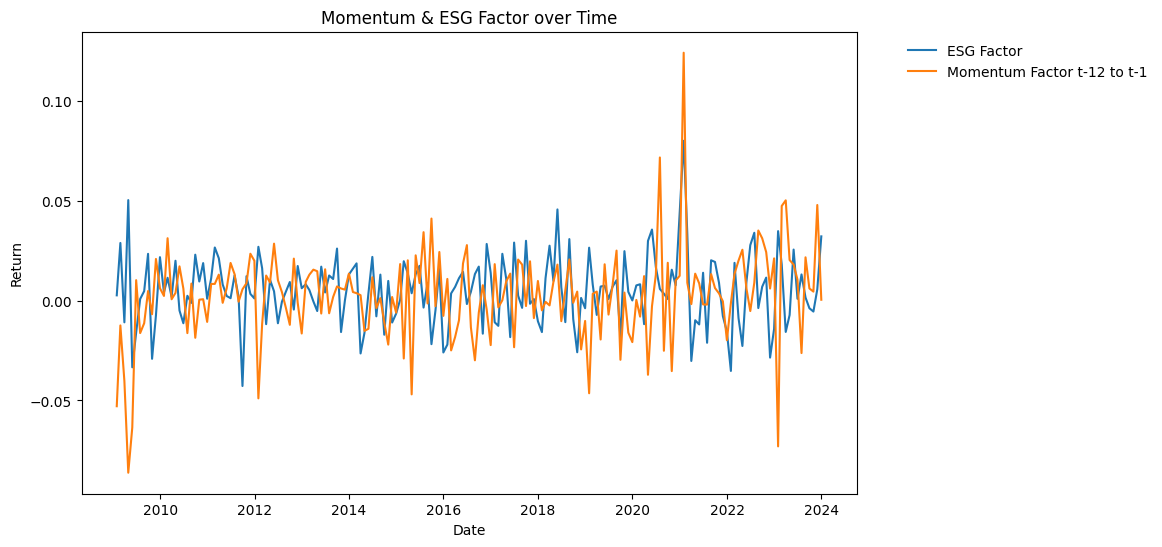

In [92]:
data_list = [data, data]
column_names = ["ESG_Factor", "Mom_12_1_Factor"]
labels = ["ESG Factor", "Momentum Factor t-12 to t-1"]

plotXReturnsOverTime(data_list, column_names, labels, "Momentum & ESG Factor over Time", "Date", "Return")


**Conclusion:**

The plot demonstrates the distinct characteristics of ESG Factor and Momentum Factor, with Momentum showing higher volatility and more extreme returns, while ESG maintains more stable performance over time. This complements the distribution plot by showing how these patterns evolved chronologically.

## **3. Fama-Macbeth Regression to Determine Risk Premiums for Factors and Visualize Correlation with Heatmap**

### **3.1 Run Regression**

In [130]:
#Copy Data for Regression to prevent altering original Data
regression_data = data.copy()

In [138]:
factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor", "Mom_12_1_Factor", "Mom_6_1_Factor"]
other_not_needed_columns = ["return_high_esg", "return_low_esg", "Date"]

stocks = [col for col in regression_data.columns if col not in (factor_columns + ["RF"] + other_not_needed_columns)]
betas = pd.DataFrame(columns=["Stock", "Intercept"] + factor_columns)

**First Stage: Extended Fama-French Regression**

In [140]:
#Run Regression
for stock in stocks:

  #Drop missing values
  current_stock_data = regression_data[["RF"] + factor_columns + [stock]].dropna()

  #Make sure regression is only done if there are at least 32 data-points.
  if len(current_stock_data) >= 32:

    Y = current_stock_data[stock] - current_stock_data["RF"] #Computes Excess Return
    X = current_stock_data[factor_columns] #Sets Factors
    X = sm.add_constant(X) #Adds constant to model

    model = sm.OLS(Y, X).fit() #Runs regression

    coefficients = model.params #Gets betas
    row = [stock] + coefficients.tolist()

    betas.loc[len(betas)] = row #Add betas

In [148]:
print(f"OLS ran for {len(betas)} stocks!")

OLS ran for 1441 stocks!


In [144]:
betas.head()

,Stock,Intercept,Mkt-RF,SMB,HML,RMW,CMA,ESG_Factor,Mom_12_1_Factor,Mom_6_1_Factor
0,A.N,0.005872,1.274857,0.271602,-0.299422,-0.297496,0.323354,-0.530570,0.308675,-0.602316
1,AA.N,0.026871,1.780757,3.662900,0.276923,0.086486,0.148749,-3.892363,-1.247136,2.001439
2,AAL.OQ,0.003486,1.277716,1.838136,0.479992,-0.042913,-0.484130,-2.058029,0.518683,-0.432214
3,AAON.OQ,0.009691,0.886925,0.915785,0.029133,0.109066,-0.280585,-0.360612,0.669981,-0.052747
4,AAP.N,-0.005099,0.707456,0.633232,-0.147409,0.959115,0.854944,0.490581,-0.736227,0.423200


**Second Stage: Regress Average Stock Excess Return on betas**

In [149]:
#Calculate average excess return
average_excess_returns = {
    stock: (data[stock] - data["RF"]).mean()
    for stock in stocks
}

#Create a dataframe with average excess returns
average_excess_df = pd.DataFrame(list(average_excess_returns.items()), columns=["Stock", "Avg_Excess_Return"])

#Merge with betas table
stage_2_data = betas.merge(average_excess_df, on = "Stock")

In [150]:
stage_2_data.head()

,Stock,Intercept,Mkt-RF,SMB,HML,RMW,CMA,ESG_Factor,Mom_12_1_Factor,Mom_6_1_Factor,Avg_Excess_Return
0,A.N,0.005872,1.274857,0.271602,-0.299422,-0.297496,0.323354,-0.530570,0.308675,-0.602316,0.017228
1,AA.N,0.026871,1.780757,3.662900,0.276923,0.086486,0.148749,-3.892363,-1.247136,2.001439,0.020151
2,AAL.OQ,0.003486,1.277716,1.838136,0.479992,-0.042913,-0.484130,-2.058029,0.518683,-0.432214,0.002053
3,AAON.OQ,0.009691,0.886925,0.915785,0.029133,0.109066,-0.280585,-0.360612,0.669981,-0.052747,0.019831
4,AAP.N,-0.005099,0.707456,0.633232,-0.147409,0.959115,0.854944,0.490581,-0.736227,0.423200,0.007799


In [202]:
stage_2_factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "ESG_Factor", "Mom_12_1_Factor", "Mom_6_1_Factor"]

stage_2_Y = stage_2_data["Avg_Excess_Return"] #Computes Excess Return
stage_2_X = stage_2_data[stage_2_factor_columns]
stage_2_X = sm.add_constant(stage_2_X) #Adds constant to model

stage_2_model = sm.OLS(stage_2_Y, stage_2_X).fit(cov_type='HC3') #Runs regression with Heteroskedasticity robust std. errors

risk_premia = stage_2_model.params
p_values = stage_2_model.pvalues

risk_premia_data = pd.DataFrame({
    "Risk Premium (%)": round(risk_premia * 100, 4),
    "P-value": round(p_values, 4)
})

In [203]:
print(stage_2_model.summary())

                            OLS Regression Results                            
Dep. Variable:      Avg_Excess_Return   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     52.61
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           5.54e-75
Time:                        17:10:58   Log-Likelihood:                 4994.9
No. Observations:                1441   AIC:                            -9972.
Df Residuals:                    1432   BIC:                            -9924.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0060      0.001     

In [204]:
risk_premia_data.head(10)

,Risk Premium (%),P-value
const,0.6037,0.0000
Mkt-RF,0.9057,0.0000
SMB,0.2285,0.0018
HML,-0.4999,0.0000
RMW,-0.1887,0.0067
CMA,-0.3709,0.0000
ESG_Factor,0.3346,0.0000
Mom_12_1_Factor,0.2320,0.1554
Mom_6_1_Factor,0.1731,0.0365


### **3.2 Calculate & Plot Pearson Correlation Coefficient**

In [172]:
def plotHeatmap(corr_matrix, title):
  plt.figure(figsize=(12, 10))

  #Plot Heatmap
  sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, fmt='.2f')

  # Move x-axis to top
  plt.gca().xaxis.set_ticks_position('top')
  plt.gca().xaxis.set_label_position('top')

  #Rotate labels on X-Axis
  plt.xticks(rotation = 45)

  #Add title
  plt.title(title)
  plt.show()

In [175]:
#Calculating Correlation Coefficients
corr_matrix = regression_data[factor_columns].corr()

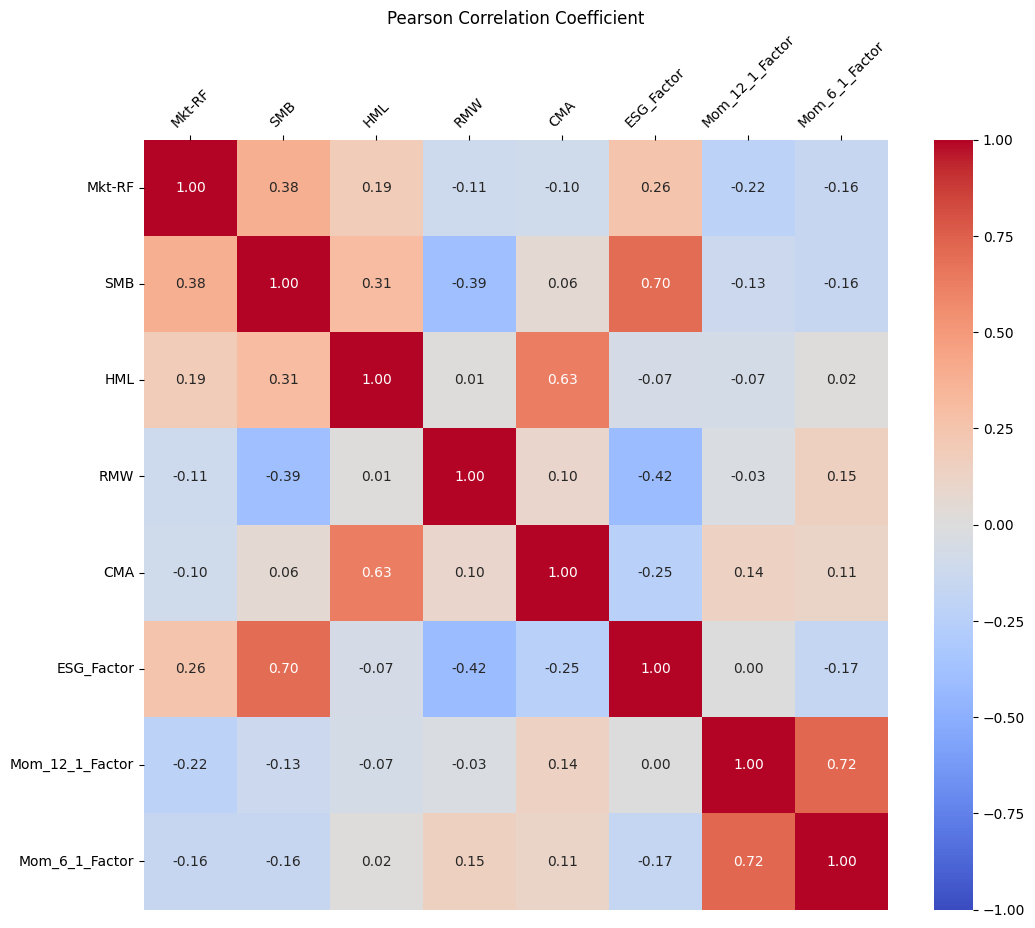

In [176]:
plotHeatmap(corr_matrix, "Pearson Correlation Coefficient")

### **3.2 Calculate & Plot Spearman Rank Correlation**

In [178]:
#Subset Data to only look at wanted columns
spearman_rank_data = regression_data[factor_columns].copy()

#Calculate Rank Correlation
spearman_corr = spearman_rank_data.corr(method = 'spearman')

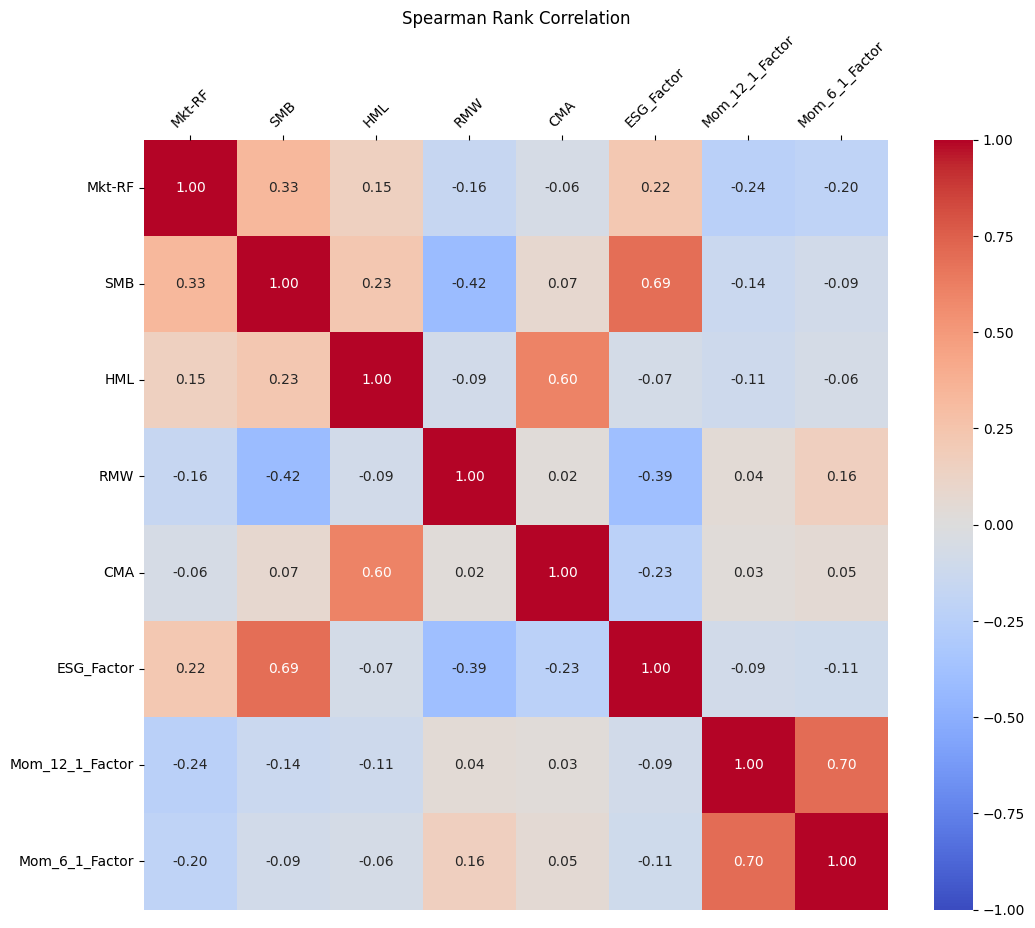

In [179]:
plotHeatmap(spearman_corr, "Spearman Rank Correlation")

### **3.3 Calculate & Plot Kendall Tau**

In [185]:
n_cols = len(factor_columns)

#Initialize empty matrix
kendall_corr_matrix = np.zeros((n_cols, n_cols))

#Counting variable for rows
row = 0

#Loop over all coefficients
for factor_1 in factor_columns:

  #Counting variable for column
  column = 0

  #Loop over all coefficients again
  for factor_2 in factor_columns:

    #Calculate Kendall Tau Correlation
    tau, _ = kendalltau(regression_data[factor_1], regression_data[factor_2])
    kendall_corr_matrix[row, column] = tau

    column = column + 1

  row = row + 1

#Convert to a DataFrame for easier plotting
kendall_tau_df = pd.DataFrame(kendall_corr_matrix, columns = factor_columns, index = factor_columns)

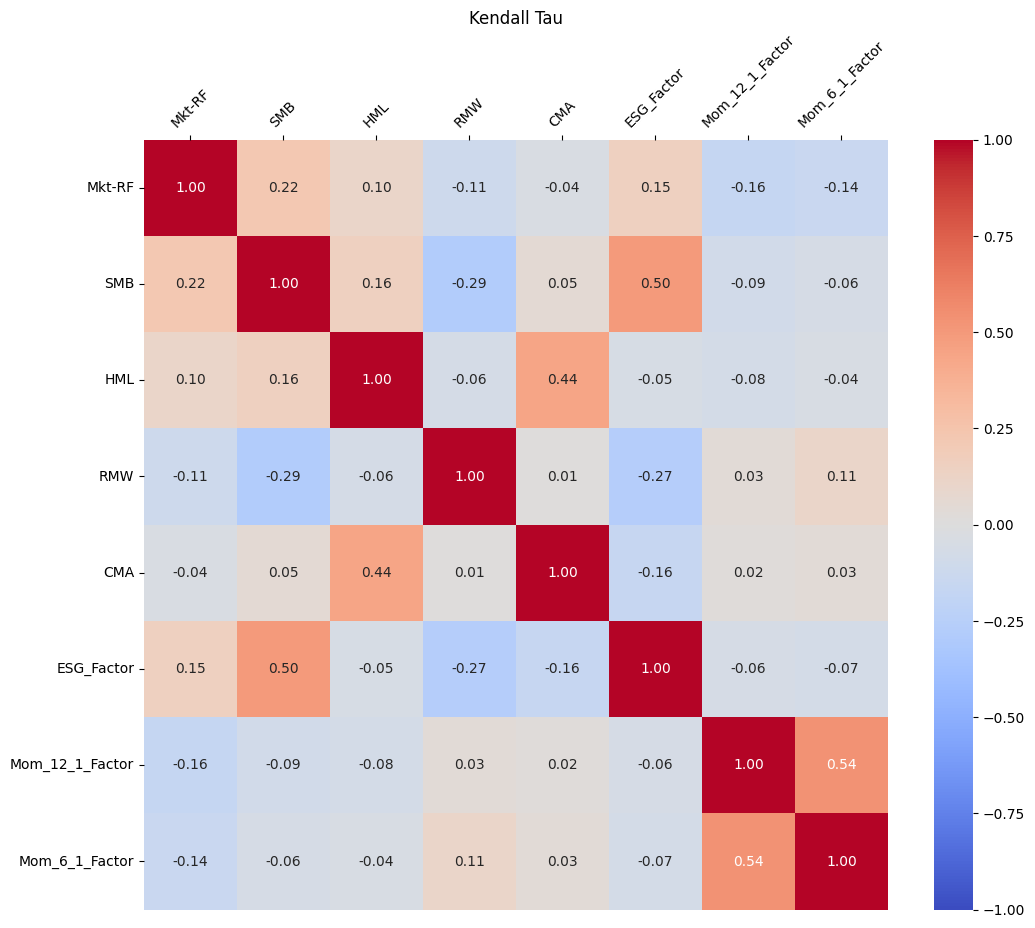

In [186]:
plotHeatmap(kendall_tau_df, "Kendall Tau") #rank-based relationships

## **4. Performance Metrics ESG Portfolios**

In [187]:
#Returns Risk Free Ratio (Averatge):
def getRiskFreeRate(data):
  return data["RF"].mean()

In [188]:
#Returns Average Return
def getAverageReturn(data, column):
  return data[column].mean() #Average Return

In [189]:
#Return Standard Deviation
def getStdDev(data, column):
  return data[column].std()

In [190]:
#Returns Annualized Return
def getAnnualizedReturn(data, column):
  avg_return = getAverageReturn(data, column)
  return (1 + avg_return) ** 12 - 1

In [191]:
#Returns Annualized Volatility
def getAnnualizedVolatility(data, column):
  std_return = getStdDev(data, column)
  return std_return * np.sqrt(12) #Assuming Monthly Data

In [192]:
#Returns Sharpe Ratio
def getSharpeRatio(data, column):

  average_return = getAverageReturn(data, column)
  std_dev = getStdDev(data, column)

  return (average_return - getRiskFreeRate(data)) / std_dev if std_dev != 0 else np.nan

In [193]:
#Returns Sortino Ratio
def getSortinoRatio(data, column):
  downside_returns = data[column][data[column] < 0]
  downside_deviation = np.sqrt((downside_returns**2).mean())

  average_return = getAverageReturn(data, column)

  return (average_return - getRiskFreeRate(data)) / downside_deviation if downside_deviation != 0 else np.nan


In [194]:
#Returns TreynorRatio
def getTreynorRatio(data, column):

  annualized_return = getAnnualizedReturn(data, column)
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  #Risk is here not the Std. Dev but beta
  beta = model.params[1]

  return (annualized_return - getRiskFreeRate(data)) / beta if beta != 0 else np.nan


In [195]:
#Returns Alpha
def getAlpha(data, column):
  market_return = data["Mkt-RF"].mean()

  X = sm.add_constant(data["Mkt-RF"])
  model = sm.OLS(data[column], X).fit()

  return model.params[0]

In [196]:
#Returns Information Ratio
def getInformationRatio(data, column):

  tracking_error = np.sqrt(((((data[column] - data["RF"]) - data["Mkt-RF"])).dropna())**2).mean()
  average_return = getAverageReturn(data, column)

  return (average_return - data["Mkt-RF"].mean()) / tracking_error if tracking_error != 0 else np.nan

In [197]:
#Returns M2 Measure (Modigliani Measure)
def getM2Measure(data, column):
  market_volatility = data["Mkt-RF"].std()
  return (getSharpeRatio(data, column) * market_volatility) + getRiskFreeRate(data)

In [198]:
round_decimals = 4

def calculatePerformanceMetrics(data, column):
  print(f"\nPerformance Metrics for {column}:")
  print(f"1. Annualized Return: {round(getAnnualizedReturn(data, column), round_decimals)}")
  print(f"2. Annualized Volatility: {round(getAnnualizedVolatility(data, column), round_decimals)}")
  print(f"3. Sharpe Ratio: {round(getSharpeRatio(data, column), round_decimals)}")
  print(f"4. Sortino Ratio: {round(getSortinoRatio(data, column), round_decimals)}")
  print(f"5. Treynor Ratio: {round(getTreynorRatio(data, column), round_decimals)}")
  print(f"6. Alpha: {round(getAlpha(data, column), round_decimals)}")
  print(f"7. Information Ratio: {round(getInformationRatio(data, column), round_decimals)}")
  print(f"8. M2 Measure: {round(getM2Measure(data, column), round_decimals)}")

In [199]:
portfolios = ['low_esg', 'high_esg']

metrics = [calculatePerformanceMetrics(regression_data, f"return_{portfolio}") for portfolio in portfolios]
metrics


Performance Metrics for return_low_esg:
1. Annualized Return: 0.2131
2. Annualized Volatility: 0.1995
3. Sharpe Ratio: 0.2703
4. Sortino Ratio: 0.2741
5. Treynor Ratio: 0.181
6. Alpha: 0.0029
7. Information Ratio: 0.3098
8. M2 Measure: 0.0131

Performance Metrics for return_high_esg:
1. Annualized Return: 0.1411
2. Annualized Volatility: 0.1779
3. Sharpe Ratio: 0.2023
4. Sortino Ratio: 0.1919
5. Treynor Ratio: 0.1304
6. Alpha: -0.0011
7. Information Ratio: -0.0268
8. M2 Measure: 0.0099


[None, None]